In [3]:
import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import yt
import numpy

import matplotlib.pyplot as plt

import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)


 using cli
 using CLI for selections


(None, <pyximport.pyximport.PyxImporter at 0x7f73c8f20810>)

In [4]:
def equil_values(init_values, primordial, t =3.16e13, niter= 1e5, full_output = False):
    
    !rm sunny*
    
    primordial.write_solver("sunny", output_dir = ".",
                            init_values=init_values,
                            input_is_number=False)

    sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                "sunny_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")
    rv, rv_int = sunny_solver_run.run_sunny(init_values, t, niter=niter) ;
    
    mask = rv_int['successful']
    
    if full_output:
        return rv_int, 0
    else:
        return rv_int['H_1'][:, mask][:,-1] / init_values['density'], rv_int['t'][mask][-1]

In [65]:
# only two species


def Init_values(temperature, density, fH):
    
    X = 1.0
    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()

    for i in range(23):
        try: 
            if (i+1) not in [3,4,5,6]:
                primordial.add_reaction("k{0:02d}".format(i+1))
        except:
            pass
    
    
    primordial.init_temperature((1e0, 1e5))

    tiny = 1e-40

    # init_array are is in fractional abundances
    init_array = density
    init_values = dict()

    init_values["H_1"]     = density * fH 
    init_values['H_2']     = tiny* density * fH
    init_values["H_m0"]    = tiny* density * fH

    init_values["H2_1"]    = density * (1.0 - fH)
    init_values["H2_2"]    = tiny * density * (1 - fH)

    # now everything in mass density
#    init_values = primordial.convert_to_mass_density(init_values)
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)
    number_density = primordial.calculate_number_density(init_values)

    # set up initial temperatures values used to define ge
    init_values['T'] = temperature

    # calculate ge (very crudely, no H2 help here)
    gamma = 5.0/3.0
    init_values['ge'] = ((temperature * number_density * kboltz)
                         / (init_values['density'] * mh * (gamma - 1)))
    return init_values, primordial

In [66]:
def main(fH, temp, den , full_output = False):
    
    
    temp = temp.flatten()
    den = den.flatten()
    
    h_array = numpy.zeros((len(temp), len(den)))
    t_array = numpy.zeros((len(den)))
    
    h_array = []
    t_array = []
    
    print(den)
    for iden, den_arr in enumerate(den):
        
        den_arr = numpy.ones((len(temp)))*den_arr
        
        init_values, primordial = Init_values(temp, den_arr, fH)
        h_array_now, t_array_now = equil_values(init_values, primordial, full_output = full_output)
        
        h_array.append(h_array_now)
        t_array.append(t_array_now)
        
    return h_array, t_array

In [67]:
class my_network:
    def __init__(self, T):
        self.T = T

from sympy import *

def equi_fH(rho, T):
    
    
    init, network = Init_values(T,rho, 0.0)
    
    # for i in network.required_species:
    #     print(network.print_ccode(i))
    #     for j in network.required_species:
    #         print(network.print_jacobian_component(i,j))

    mH = 1.0

    k13 = (network.reactions['k13'])
    k22 = (network.reactions['k22'])

    temp_network = my_network(T)

    k13coeff, k22coeff = (k13.coeff_fn(temp_network), k22.coeff_fn(temp_network))
    

    k13s, k22s, fHs, rhos = symbols(" k13 k22 fH rho")
    expr = k13s*(1 - fHs) /2 - k22s*fHs*fHs*rhos
    known_vals = [ (k13s, k13coeff), (k22s, k22coeff), (rhos, rho) ]
    new_expr = expr.subs(known_vals)
    new_expr_poly = Poly(new_expr, fHs)
    print('Temperature now: {} K'.format(T))
    poly_coeff = (new_expr_poly.coeffs())
    ans = numpy.roots(poly_coeff)
    print('fH: {}'.format(ans[ans>0]) )
    return ans[ans>0]

Temp_array = numpy.logspace(2, 4, 10)

Temp_array = numpy.array([5.0e3])
# in atomic mass unit! not grams
rho = numpy.array([1e20])

for ith_T in Temp_array:
    fH = equi_fH(rho, ith_T)
    h , t = main(fH, ith_T, rho , full_output = True)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 + 1*H2_1 => 2*H2_1
Adding reaction: k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1
Adding reaction: k23 : 1*H2_1 + 1*H2_1 => 2*H_1 + 1*H2_1
Temperature now: 5000.0 K
fH: [ 0.26671495]
[  1.00000000e+20]
Adding r

In [70]:
con_not_con = 'not-conserved'

mask = h[0]['successful']
t = h[0]['t'][mask]
dt = h[0]['dt'][mask]

plt.clf()
skip_list = ['dt', 'ge', 'successful', 't']
hydrogen_list = ['H_1','H_2','H2_1','H2_2','H_m0']

total_e = numpy.zeros((len(t)))
init, network = Init_values(5e3,1e15, 0.0)

for j in network.required_species:
    if j.name in h[0].keys() and j.name not in skip_list:
        total_e += h[0][j.name][0][mask]  * j.free_electrons

total_Hatoms = numpy.zeros((len(t)))
for j in network.required_species:
    if j.name in hydrogen_list:
        total_Hatoms += h[0][j.name][0][mask] *j.weight


        
f, axarr = plt.subplots(3, sharex=True, figsize=(10,15))
        
for i in h[0].keys():
    if i not in skip_list:
        print(i)
        hi = h[0][i][0][mask]
        axarr[0].loglog(t,hi/hi[0], label=i) 


        

h1 = h[0]['H_1'][0][mask]
h2 = h[0]['H2_1'][0][mask]
#de = h[0]['de'][0][mask]

axarr[0].set_title('Temperature: {} K     Density: {} per cc   with {} iterations'.format(Temp_array[0],  rho[0], 1e5))
axarr[0].set_xlabel('Time (s)')
axarr[0].set_ylabel('Species abundances (normalized by initial values)')
axarr[0].loglog(t,dt/dt[0], label='dt')

if con_not_con == 'not-conserved':
    
    de = h[0]['de'][0][mask]
    axarr[0].loglog(t, total_e/de, label='de normalized by those from species', ls = '--', color = 'r')

axarr[0].legend(loc='best',fontsize='x-small')
# plt.savefig(con_not_con+'-species-norm-nHe20.png')


for i in h[0].keys():
    if i not in skip_list:
        print(i)
        hi = h[0][i][0][mask]
        axarr[1].loglog(t,hi, label=i) 


#axarr[1].set_xlim(1e-9, 1e10)

h1 = h[0]['H_1'][0][mask]
h2 = h[0]['H2_1'][0][mask]



axarr[1].set_xlabel('Time (s)')
axarr[1].set_ylabel('Species abundances')
axarr[1].loglog(t,dt, label='dt')
axarr[1].loglog(t, total_e, label='de (from species)', ls = '--', color = 'r')

axarr[1].legend(loc='best',fontsize='x-small')
# plt.savefig(con_not_con+'-species-nHe20.png')


if con_not_con == 'not-conserved':
    
    de = h[0]['de'][0][mask]
    axarr[2].semilogx(t, (total_e/de) , label='de normalized by those from species', ls = '--', color = 'r')


axarr[2].plot(t, h1/total_Hatoms, label="f(H)" )
axarr[2].set_xlabel('Time (s)')
axarr[2].set_ylabel('mass ratio of Hydrogen atom (fH)')
axarr[2].legend()
f.savefig(con_not_con+'nHe20.png')

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 + 1*H2_1 => 2*H2_1
Adding reaction: k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1
Adding reaction: k23 : 1*H2_1 + 1*H2_1 => 2*H_1 + 1*H2_1
H_2
H_1
Ju
de
H2_2
H2_1
H_m0
T
H_2
H_1
Ju
de
H2_2
H2_1
H_m0
T


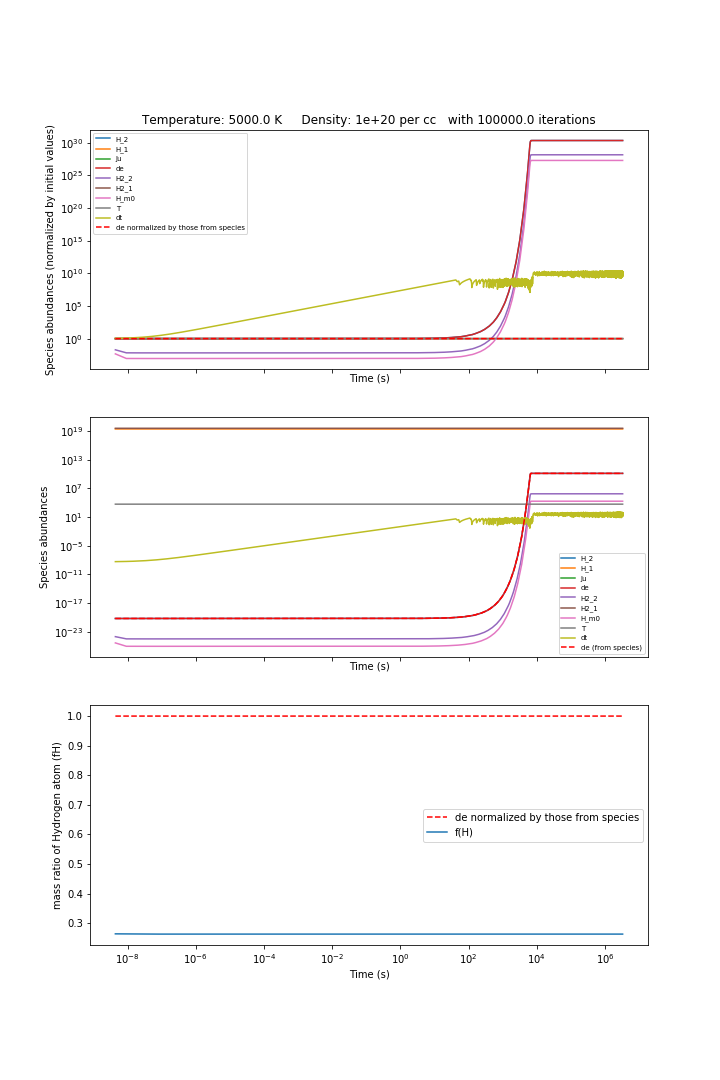

In [71]:
from IPython.display import Image
Image(con_not_con+'nHe20.png')

In [16]:
flag = (result_H[0][0]['successful'])

valid_results = result_H[0][0]
total_e = numpy.zeros((len(flag[flag])))

for s in network.required_species:
    
    species_now = numpy.array((valid_results[s.name][0][flag]))
    
    if s.name in ['de', 'ge']: continue        
    total_e += species_now * s.free_electrons
    print(s.name, species_now[-1] , s.free_electrons)

try:
    plt.semilogx( valid_results['t'][flag] , (valid_results['de'][0][flag])/total_e, label='ratio of de to the actual charge')
except:
    pass
#plt.scatter(valid_results['t'][flag] , total_e, color = 'r')
#plt.semilogx( valid_results['t'][flag] , valid_results['H_m0'][0][flag] / max(valid_results['H_m0'][0][flag]),label='H_m0 (relative to max)')
#plt.semilogx( valid_results['t'][flag] , valid_results['H2_2'][0][flag] / max(valid_results['H2_2'][0][flag]),label='H2_2 (relative to max)')
plt.legend()
plt.show()

NameError: name 'result_H' is not defined

In [ ]:
from matplotlib import cm
import matplotlib.pyplot as plt

cm_section = numpy.linspace(0,1.0, len( result_H[0][0].keys()))
colors = [cm.jet(x) for x in cm_section ]

abase = result_H[0][0]

tol = [1e-6,1e-3,1.0]

for i in [0,1,2]:
    
    
    plt.clf()
    plt.figure(figsize = (8,8))

    ls = ['-', '--', ':','-.']
    a = result_H[i][0]
    skip_list = ['t', 'successful', 'dt', 'ge']
    icolor = 0
    for key in a.keys():
        if key not in skip_list:
            baseb = (abase[key])
            mask = a['successful']
            b = (a[key][0][mask])
            t = (a['t'][mask])
            plt.loglog(t, (b)/b[0], label = key, ls = ls[i], color= colors[icolor])
        icolor = icolor + 1

    plt.scatter(t, a['dt'][mask] / a['dt'][mask][0],label='dt')
    plt.ylim(1e-2,1e2)
    plt.xlim((0 ,1e13))
    
    plt.plot(t, total_e/a['de'][0][mask], color='r', ls = '--')
#    plt.plot(t, a['de'][0][mask], color='g', ls = '--')
    
#    plt.title('atol = {}'.format( tol[i]))

    plt.legend(loc='upper right',fontsize = 'x-small')
    plt.show()

In [ ]:
hehe.T

In [ ]:
from sympy import *

k13s, k22s, fHs, rhos = symbols(" k13 k22 fH rho")
expr = k13s*(1 - fHs) /2 - k22s*fHs*fHs*rhos
known_vals = [ (k13s, k13coeff), (k22s, k22coeff), (rhos, rho) ]
new_expr = expr.subs(known_vals)

In [ ]:
print(new_expr)
f = lambdify(fHs, new_expr, 'numpy')
f(0.1)

In [ ]:
numpy.roots([-1.37064198972626e-38, 1.48658174786701e-11,1.48658174786701e-11])

In [ ]:
rho

In [ ]:
k22coeff

In [ ]:
from IPython.display import Image

Image(filename='trytry.png')

In [30]:
h1 = h[0]['Ju']
h1[:,mask].shape
sp_arr = [sp.name for sp in sorted(network.required_species)]

jacs = h1[:,mask]

In [31]:
from ipywidgets import interact
def jac_plot(i):
    plt.imshow( numpy.log( numpy.abs(jacs[:,i].reshape(7, 7)) ) ,origin='lower')
    plt.colorbar()
    plt.xticks(range(7), sp_arr)
    plt.yticks(range(7), sp_arr)
    plt.show()
    
    plt.hist(jacs[:,i])
    plt.show()
interact(jac_plot, i = (0, h1[:,mask].shape[1]))

<function __main__.jac_plot>

In [ ]:
hm0 = h[0]['H_m0'][0][mask]
de = h[0]['de'][0][mask]


In [ ]:
plt.plot(t, hm0/de)
plt.plot(t, total_e/de)

plt.show()

In [58]:
a = network.reactions['k01']

In [61]:
class my_network:
    def __init__(self, T):
        self.T = T

from sympy import *

def equi_fH(rho, T):
    
    
    init, network = Init_values(T,rho, 0.0)
    
    # for i in network.required_species:
    #     print(network.print_ccode(i))
    #     for j in network.required_species:
    #         print(network.print_jacobian_component(i,j))

    mH = 1.0

    k13 = (network.reactions['k13'])
    k22 = (network.reactions['k22'])

    temp_network = my_network(T)

    k13coeff, k22coeff = (k13.coeff_fn(temp_network), k22.coeff_fn(temp_network))
    

    k13s, k22s, fHs, rhos = symbols(" k13 k22 fH rho")
    expr = k13s*(1 - fHs) /2 - k22s*fHs*fHs*rhos
    known_vals = [ (k13s, k13coeff), (k22s, k22coeff), (rhos, rho) ]
    new_expr = expr.subs(known_vals)
    new_expr_poly = Poly(new_expr, fHs)
    print('Temperature now: {} K'.format(T))
    poly_coeff = (new_expr_poly.coeffs())
    ans = numpy.roots(poly_coeff)
    print('fH: {}'.format(ans[ans>0]) )
    return ans[ans>0]

Temp_array = numpy.logspace(2, 4, 10)

Temp_array = numpy.array([3.0e3])
# in atomic mass unit! not grams
rho = numpy.array([1e20])

for ith_T in Temp_array:
    fH = equi_fH(rho, ith_T)
    h , t = main(fH, ith_T, rho , full_output = True)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 + 1*H2_1 => 2*H2_1
Adding reaction: k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1
Adding reaction: k23 : 1*H2_1 + 1*H2_1 => 2*H_1 + 1*H2_1
Temperature now: 3000.0 K
fH: [ 0.00938032]
[  1.00000000e+20]
Adding r

In [62]:
sp_arr

['H2_1', 'H2_2', 'H_1', 'H_2', 'H_m0', 'de', 'ge']

In [25]:
network.reactions

{'k01': k01 : 1*H_1 + 1*de => 1*H_2 + 2*de,
 'k02': k02 : 1*H_2 + 1*de => 1*H_1,
 'k07': k07 : 1*H_1 + 1*de => 1*H_m0,
 'k08': k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de,
 'k09': k09 : 1*H_1 + 1*H_2 => 1*H2_2,
 'k10': k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2,
 'k11': k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1,
 'k12': k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de,
 'k13': k13 : 1*H2_1 + 1*H_1 => 3*H_1,
 'k14': k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de,
 'k15': k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de,
 'k16': k16 : 1*H_m0 + 1*H_2 => 2*H_1,
 'k17': k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de,
 'k18': k18 : 1*H2_2 + 1*de => 2*H_1,
 'k19': k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1,
 'k21': k21 : 2*H_1 + 1*H2_1 => 2*H2_1,
 'k22': k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1,
 'k23': k23 : 1*H2_1 + 1*H2_1 => 2*H_1 + 1*H2_1}

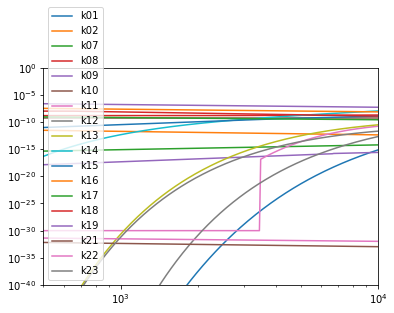

In [45]:
plt.clf()
for i in range(23):
    try: 
        rxn = network.reactions["k{0:02d}".format(i+1)]
        plt.loglog(network.T , rxn.coeff_fn(network), label= "k{0:02d}".format(i+1))
        
    except:
        pass
plt.legend()
plt.ylim(1e-40, 1e0)
plt.xlim(5e2,1e4)
plt.show()

In [9]:
dengo.primordial_rates.setup_primordial()
network = ChemicalNetwork()
print(network)
for i in range(23):
    
    try: 
        network.add_reaction("k{0:02d}".format(i+1))
        rxn = network.reactions["k{0:02d}".format(i+1)]
    except:
        pass
    
    left_e = 0.0
    right_e = 0.0
    
    for num, sp in rxn.left_side:
        if sp.name == 'de':
            left_e += num* -1.0
        left_e += num* sp.free_electrons
    for num, sp in rxn.right_side:
        if sp.name == 'de':
            right_e += num* -1.0
        right_e += num* sp.free_electrons
    print("k{0:02d}".format(i+1), left_e, right_e)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
('k01', -1.0, -1.0)
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
('k02', 0.0, 0.0)
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
('k03', -1.0, -1.0)
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
('k04', 0.0, 0.0)
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
('k05', 0.0, 0.0)
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
('k06', 1.0, 1.0)
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
('k07', -1.0, -1.0)
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
('k08', -1.0, -1.0)
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
('k09', 1.0, 1.0)
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
('k10', 1.0, 1.0)
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
('k11', 1.0, 1.0)
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
('k12', -1.0, -1.0)
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
('k13', 0.0, 0.0)
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
('k14', -2.0, -2.0)
Adding reaction: k15 : 1

In [102]:
sp = (rxn.left_side[0][1])

sp.free_electrons

0.0

In [19]:
eq = sympify("0")
for sp in network.required_species:
    if sp.name not in ['de', 'ge']:
        print(sp.name, network.species_total(sp))
        eq += sp.free_electrons * ( network.species_total(sp))
    elif sp.name == 'de':
        eq_e = network.species_total(sp)

print(eq)
print(eq_e)

print('---------------')
print(eq - eq_e)

('H2_2', k09[i]*H_1*H_2 - k10[i]*H2_2*H_1 + k11[i]*H2_1*H_2 + k17[i]*H_2*H_m0 - k18[i]*H2_2*de - k19[i]*H2_2*H_m0)
('H_m0', k07[i]*H_1*de - k08[i]*H_1*H_m0 - k14[i]*H_m0*de - k15[i]*H_1*H_m0 - k16[i]*H_2*H_m0 - k17[i]*H_2*H_m0 - k19[i]*H2_2*H_m0)
('H2_1', k08[i]*H_1*H_m0 + k10[i]*H2_2*H_1 - k11[i]*H2_1*H_2 - k12[i]*H2_1*de - k13[i]*H2_1*H_1 + k19[i]*H2_2*H_m0 + k21[i]*H2_1*H_1**2 + k22[i]*H_1**3 - k23[i]*H2_1**2)
('H_1', -k01[i]*H_1*de + k02[i]*H_2*de - k07[i]*H_1*de - k08[i]*H_1*H_m0 - k09[i]*H_1*H_2 - k10[i]*H2_2*H_1 + k11[i]*H2_1*H_2 + 2*k12[i]*H2_1*de + 2*k13[i]*H2_1*H_1 + k14[i]*H_m0*de + k15[i]*H_1*H_m0 + 2*k16[i]*H_2*H_m0 + 2*k18[i]*H2_2*de + k19[i]*H2_2*H_m0 - 2*k21[i]*H2_1*H_1**2 - 2*k22[i]*H_1**3 + 2*k23[i]*H2_1**2)
('H_2', k01[i]*H_1*de - k02[i]*H_2*de - k09[i]*H_1*H_2 + k10[i]*H2_2*H_1 - k11[i]*H2_1*H_2 - k16[i]*H_2*H_m0 - k17[i]*H_2*H_m0)
1.0*k01[i]*H_1*de - 1.0*k02[i]*H_2*de - 1.0*k07[i]*H_1*de + 1.0*k08[i]*H_1*H_m0 + 1.0*k14[i]*H_m0*de + 1.0*k15[i]*H_1*H_m0 + 1.0*k17[i]*

In [59]:
sp_arr

['H2_1', 'H2_2', 'H_1', 'H_2', 'H_m0', 'de', 'ge']

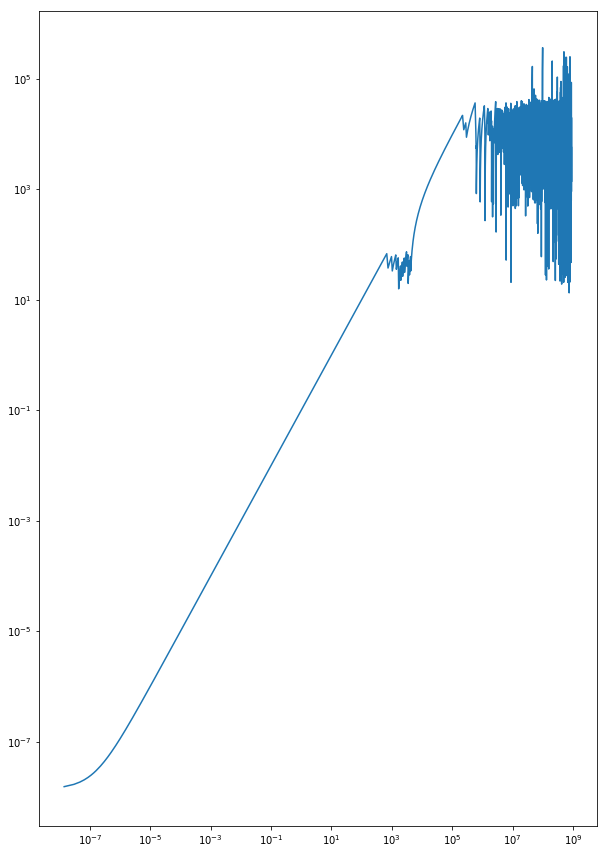

In [82]:
plt.clf()
plt.loglog(t,dt)
plt.show()

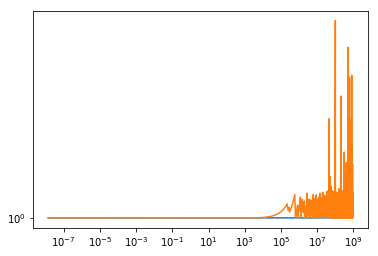

In [85]:
T = h[0]['T'][0][mask]

plt.clf()
plt.semilogx(t,T/max(T))
plt.loglog(t,dt/max(dt) / (max(T) - min(T) ) + 1)

plt.show()

In [63]:
(max(T) - min(T) )

1.0356974989617811

('H2_2', 2.01588)
('H_m0', 1.00794)
('H2_1', 2.01588)
('H_1', 1.00794)
('H_2', 1.00794)
H2_1
H_1


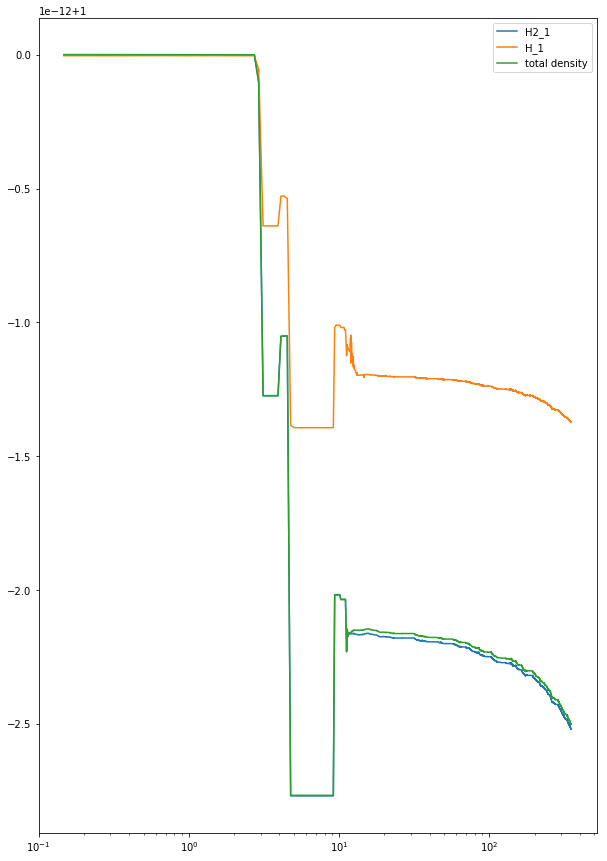

In [60]:
plt.clf()
ll = len(h[0][sp.name][0][mask])
all_mass = numpy.zeros((ll))

for sp in network.required_species:
    if sp.name not in ['dt', 'ge', 'de']:
        T = h[0][sp.name][0][mask]
        print(sp.name, sp.weight)
        all_mass +=  T

for sp in network.required_species:
    if sp.name not in ['dt', 'ge', 'H2_2', 'H_2', 'H_m0', 'de']:
        T = h[0][sp.name][0][mask]
        print(sp.name)
        plt.semilogx(t ,T/ max(T) , label=sp.name)
        plt.legend()
        
plt.semilogx(t , all_mass / max(all_mass), label='total density')

T = h[0]['T'][0][mask]
#plt.semilogx( t[t>1e3]  , T[t>1e3] /max(T[t>1e3] ) , label = 'T' )

#plt.semilogx( t[t>1e3]  , total_e[t>1e3]  / de[t>1e3]  , label = 'ele' )
plt.legend()
plt.show()

In [24]:
eq = sympify("0")
for sp in network.required_species:
    if sp.name not in ['ge', 'de']:
        print(sp)
        eq += sp.weight * ( network.species_total(sp))
    elif sp.name == 'de':
        eq_e = network.species_total(sp)
        
print(eq)

Species: H2_2
Species: H_m0
Species: H2_1
Species: H_1
Species: H_2
-k08[i]*H_1*H_m0 - k09[i]*H_1*H_2 + k12[i]*H2_1*de + k13[i]*H2_1*H_1 - k17[i]*H_2*H_m0 + k18[i]*H2_2*de - k21[i]*H2_1*H_1**2 - k22[i]*H_1**3 + k23[i]*H2_1**2


In [17]:
for i in range(23):
    try: 
        rxn = network.reactions["k{0:02d}".format(i+1)]
    except:
        pass
    
    left_e = 0.0
    right_e = 0.0
    
    for num, sp in rxn.left_side:
        if sp.name == 'de':
            left_e += num* 0.0
        else:
            left_e += num* sp.weight
    for num, sp in rxn.right_side:
        if sp.name == 'de':
            right_e += num* 0.0
        else:
            right_e += num* sp.weight
    print("k{0:02d}".format(i+1), left_e, right_e)

('k01', 1.00794, 1.00794)
('k02', 1.00794, 1.00794)
('k03', 1.00794, 1.00794)
('k04', 1.00794, 1.00794)
('k05', 1.00794, 1.00794)
('k06', 1.00794, 1.00794)
('k07', 1.00794, 1.00794)
('k08', 2.01588, 2.01588)
('k09', 2.01588, 2.01588)
('k10', 3.02382, 3.02382)
('k11', 3.02382, 3.02382)
('k12', 2.01588, 2.01588)
('k13', 3.02382, 3.02382)
('k14', 1.00794, 1.00794)
('k15', 2.01588, 2.01588)
('k16', 2.01588, 2.01588)
('k17', 2.01588, 2.01588)
('k18', 2.01588, 2.01588)
('k19', 3.02382, 3.02382)
('k20', 3.02382, 3.02382)
('k21', 4.03176, 4.03176)
('k22', 3.02382, 3.02382)
('k23', 4.03176, 4.03176)


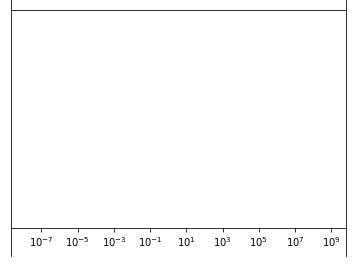

In [22]:
plt.loglog(t, h[0]['ge'][0][mask] )
plt.show()

In [31]:
1.00794*2

2.01588

In [15]:
import yt

In [16]:
from yt.units import u

ImportError: cannot import name u